In [2]:
import numpy as np
import pandas as pd
from igraph import *
import matplotlib.pyplot as plt
import copy

### Implementation of building FP-tree

In [3]:
def fp_tree(T, min_supp_percent, min_conf_percent):
    #create header table
    t = ''.join(T)
    unique, counts = np.unique(list(t), return_counts=True)
    header_table = pd.DataFrame(np.array([unique, counts]).T, columns=['ele', 'supp'])
    header_table = header_table.sort_values(by=['supp', 'ele'], ascending=[False, True]).reset_index(drop=True)
    header_table.supp = header_table.supp.astype(int)
    min_supp = min_supp_percent * len(T)
    header_table = header_table[header_table["supp"] >= min_supp] 
    print("Header table: \n", header_table)
    #sort elements in transaction by support
    for i, t in enumerate(T):
        new_t = []
        for ele in header_table['ele']:
            if ele in list(t):
                new_t.append(ele)
        T[i] = new_t
    
    # sort transactions by support for plot graph
    while True:
        T_prev = copy.copy(T)
        for i in range(len(T)-1):
            for j in range(np.min([len(T[i]), len(T[i+1])])):
                if T[i][j] == T[i+1][j]:
                    continue
                else:
                    for k in header_table['ele']:
                        if T[i][j] == k:
                            break
                        elif T[i+1][j] == k:
                            temp = copy.copy(T[i])
                            T[i] = T[i+1]
                            T[i+1] = temp
                            break
        if T == T_prev:
            break

    # add nodes to graph
    def insert(idx, t):
        neighbors_idxs = np.array(g.neighbors(idx))
        neighbors_idxs = list(neighbors_idxs[neighbors_idxs > idx])

        neighbors_names = g.vs[neighbors_idxs]["name"]
        try:
            jdx = neighbors_idxs[neighbors_names.index(t[0])]
            g.vs[jdx]["quantity"] += 1
        except:
            g.add_vertices(1)
            jdx = len(g.vs["name"])-1
            g.vs[jdx]["name"] = t[0]
            g.vs[jdx]["quantity"] = 1
            g.add_edges([(jdx, idx)])
            kdx = len(g.es)-1
            g.es["is_main"] = True
        if len(t) > 1:
            insert(jdx, t[1:])
    
    #create tree
    g = Graph()
    g.add_vertices(1)
    g.vs[0]["name"] = "null"
    g.vs[0]["quantity"] = 0
    for t in T:
        insert(0, t)
    labels = [":".join([name, str(n)]) for name, n in zip(g.vs["name"], g.vs["quantity"])]
    labels[0] = "null"
    
    # add egdes among repeating elements
    name = g.vs["name"]
    idxs = np.arange(len(g.vs["name"]))

    for i in range(len(name)):
        for j in range(len(name))[i+1:]:
            if name[i] == name[j] and i != j:
                g.add_edges([(idxs[i], idxs[j])])
                kdx = len(g.es)-1
                g.es[kdx]["is_main"] = False
                break
    return g

### Testing on data a)

Header table: 
   ele  supp
0   b     8
1   a     7
2   c     7
3   d     5


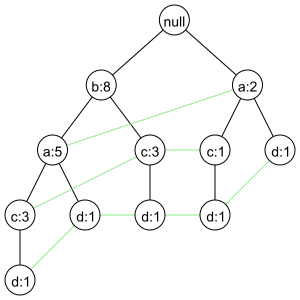

In [4]:
T = ['ab', 'bcd', 'acde', 'ade', 'abc', 'abcd', 'bc', 'abc', 'abd', 'bce']
min_supp_percent = 0.4
g = fp_tree(T, min_supp_percent, None)

#plot tree
labels = [":".join([name, str(n)]) for name, n in zip(g.vs["name"], g.vs["quantity"])]
labels[0] = "null"
edge_color = ["black" if is_main else "lightgreen" for is_main in g.es["is_main"]]
plot(g, vertex_label=labels, vertex_size = 30, vertex_color = "white",
     edge_color = edge_color, layout=g.layout('rt',root=[0]),bbox=(300,300))

### Testing on data b)

Header table: 
   ele  supp
0   b     4
1   e     4
2   d     3
3   a     2
4   c     2


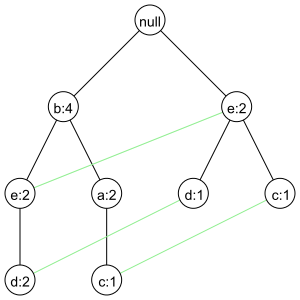

In [5]:
T = ['abc', 'ab', 'bde', 'de', 'ec', 'bde']
min_supp_percent = 0.33
min_conf_percent = 0.6
g = fp_tree(T, min_supp_percent, min_conf_percent)

#plot tree
labels = [":".join([name, str(n)]) for name, n in zip(g.vs["name"], g.vs["quantity"])]
labels[0] = "null"
edge_color = ["black" if is_main else "lightgreen" for is_main in g.es["is_main"]]
plot(g, vertex_label=labels, vertex_size = 30, vertex_color = "white",
     edge_color = edge_color, layout=g.layout('rt',root=[0]),bbox=(300,300))